# Análisis de la Asociación entre Tiempo de Exposición a Pantallas y SVI en Médicos Radiólogos

Este notebook analiza la relación entre el tiempo de exposición a pantallas y el Síndrome Visual Informático (SVI) en médicos radiólogos, utilizando un enfoque de modelado estadístico inferencial.

## Objetivos
1. Analizar asociaciones bivariadas entre predictores y SVI
2. Desarrollar modelos de regresión logística
3. Identificar factores de riesgo significativos
4. Proporcionar recomendaciones basadas en evidencia

In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración de visualización
plt.style.use('default')  # Usar estilo por defecto en lugar de seaborn
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Carga y Preparación de Datos

Cargaremos el dataset simulado y realizaremos la preparación inicial de los datos.

In [4]:
# Cargar el dataset
df = pd.read_csv('d:/encuesta_fatiga_visual/data/2_processed/df_models_synthetic.csv')

# Verificar las dimensiones y primeras filas
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (60, 64)


,edad,experiencia_radiologia,tiempo_de_exposicion,duracion_de_jornada,sexo,estado_civil,ingresos_mensuales,condiciones_oculares,lentes,iluminacion,frecuencia_de_pausas,uso_de_dispositivos,distancia_hacia_el_monitor,ardor_frecuencia,ardor_intensidad,ardor_severidad,picor_frecuencia,picor_intensidad,picor_severidad,sensacion_cuerpo_extraño_frecuencia,sensacion_cuerpo_extraño_intensidad,sensacion_cuerpo_extraño_severidad,lagrimeo_frecuencia,lagrimeo_intensidad,lagrimeo_severidad,parpadeo_excesivo_frecuencia,parpadeo_excesivo_intensidad,parpadeo_excesivo_severidad,enrojecimiento_ocular_frecuencia,enrojecimiento_ocular_intensidad,enrojecimiento_ocular_severidad,dolor_ocular_frecuencia,dolor_ocular_intensidad,dolor_ocular_severidad,pesadez_parpados_frecuencia,pesadez_parpados_intensidad,pesadez_parpados_severidad,sequedad_frecuencia,sequedad_intensidad,sequedad_severidad,vision_borrosa_frecuencia,vision_borrosa_intensidad,vision_borrosa_severidad,vision_doble_frecuencia,vision_doble_intensidad,vision_doble_severidad,dificultad_al_enfocar_frecuencia,dificultad_al_enfocar_intensidad,dificultad_al_enfocar_severidad,aumento_sensiblidad_luz_frecuencia,aumento_sensiblidad_luz_intensidad,aumento_sensiblidad_luz_severidad,halos_de_colores_frecuencia,halos_de_colores_intensidad,halos_de_colores_severidad,sensacion_de_ver_peor_frecuencia,sensacion_de_ver_peor_intensidad,sensacion_de_ver_peor_severidad,dolor_de_cabeza_frecuencia,dolor_de_cabeza_intensidad,dolor_de_cabeza_severidad,puntaje_sindrome_visual_informatico,svi,severidad_svi
0,37,2.8,15.0,15.0,0,0,1,1,1,0,0,1,0,2,1,2,1,1,1,0,0,0,1,1,1,1,2,2,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,4,1,1,1,1,1,1,2,2,4,1,1,1,21,1,Severo
1,33,3.7,8.0,9.0,0,0,2,1,1,1,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,3,0,No SVI
2,38,1.0,16.0,8.0,0,0,2,0,1,1,0,3,1,2,1,2,1,1,1,2,1,2,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,2,1,2,2,1,2,2,2,4,1,1,1,0,0,0,2,1,2,0,0,0,0,0,0,20,1,Moderado
3,43,1.0,8.0,14.0,1,1,1,0,1,0,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,2,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,No SVI
4,33,6.9,14.0,11.0,1,0,0,1,1,1,1,3,0,0,0,0,2,1,2,2,2,4,2,1,2,1,1,1,1,1,1,2,1,2,0,0,0,1,1,1,2,1,2,1,1,1,1,1,1,2,2,4,2,1,2,1,2,2,1,1,1,26,1,Severo


In [5]:
# Verificar tipos de datos y valores faltantes
print("\nTipos de datos:")
print(df.dtypes)
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Tipos de datos:
edad                                     int64
experiencia_radiologia                 float64
tiempo_de_exposicion                   float64
duracion_de_jornada                    float64
sexo                                     int64
estado_civil                             int64
ingresos_mensuales                       int64
condiciones_oculares                     int64
lentes                                   int64
iluminacion                              int64
frecuencia_de_pausas                     int64
uso_de_dispositivos                      int64
distancia_hacia_el_monitor               int64
ardor_frecuencia                         int64
ardor_intensidad                         int64
ardor_severidad                          int64
picor_frecuencia                         int64
picor_intensidad                         int64
picor_severidad                          int64
sensacion_cuerpo_extraño_frecuencia      int64
sensacion_cuerpo_extraño_intensidad      in

## 2. Análisis Descriptivo por Grupos SVI

Crearemos tablas de resumen comparando las características entre grupos con y sin SVI.

In [6]:
# Función para calcular estadísticas descriptivas por grupo
def get_descriptive_stats(df, group_col, num_cols):
    stats = []
    for col in num_cols:
        group_stats = df.groupby(group_col)[col].agg(['mean', 'std', 'median', 'count'])
        stats.append(pd.DataFrame(group_stats))
    return pd.concat(stats, keys=num_cols, axis=0)

# Variables numéricas
num_vars = ['edad', 'experiencia_radiologia', 'tiempo_de_exposicion', 'duracion_de_jornada']

# Calcular estadísticas descriptivas por grupo SVI
desc_stats = get_descriptive_stats(df, 'svi', num_vars)
print("Estadísticas descriptivas por grupo SVI:")
print(desc_stats)

Estadísticas descriptivas por grupo SVI:
                                 mean       std  median  count
                       svi                                    
edad                   0    32.500000  5.402020   33.50     12
                       1    33.375000  5.167925   33.00     48
experiencia_radiologia 0     3.291667  2.419037    2.95     12
                       1     4.843750  2.530907    4.55     48
tiempo_de_exposicion   0     8.416667  0.668558    8.00     12
                       1    12.979167  2.613301   13.00     48
duracion_de_jornada    0    11.250000  3.493500   11.50     12
                       1    12.083333  3.187965   13.00     48


In [7]:
# Tabla de frecuencias para variables categóricas
cat_vars = ['sexo', 'estado_civil', 'condiciones_oculares', 'lentes', 
            'iluminacion', 'frecuencia_de_pausas', 'uso_de_dispositivos',
            'distancia_hacia_el_monitor']

def get_categorical_freqs(df, group_col, cat_cols):
    results = {}
    for col in cat_cols:
        freq_table = pd.crosstab(df[col], df[group_col], margins=True)
        prop_table = pd.crosstab(df[col], df[group_col], normalize='columns') * 100
        results[col] = {'counts': freq_table, 'percentages': prop_table}
    return results

cat_freqs = get_categorical_freqs(df, 'svi', cat_vars)
for var in cat_vars:
    print(f"\nFrecuencias para {var}:")
    print(cat_freqs[var]['counts'])
    print("\nPorcentajes:")
    print(cat_freqs[var]['percentages'].round(2))


Frecuencias para sexo:
svi    0   1  All
sexo             
0      7  25   32
1      5  23   28
All   12  48   60

Porcentajes:
svi       0      1
sexo              
0     58.33  52.08
1     41.67  47.92

Frecuencias para estado_civil:
svi            0   1  All
estado_civil             
0              4  20   24
1              6  15   21
2              1   8    9
3              1   5    6
All           12  48   60

Porcentajes:
svi               0      1
estado_civil              
0             33.33  41.67
1             50.00  31.25
2              8.33  16.67
3              8.33  10.42

Frecuencias para condiciones_oculares:
svi                    0   1  All
condiciones_oculares             
0                      2  16   18
1                     10  32   42
All                   12  48   60

Porcentajes:
svi                       0      1
condiciones_oculares              
0                     16.67  33.33
1                     83.33  66.67

Frecuencias para lentes:
svi      0   1  

## 3. Análisis de Asociación Bivariada

Realizaremos pruebas chi-cuadrado para variables categóricas y pruebas t/Mann-Whitney para variables continuas.

In [8]:
# Pruebas chi-cuadrado para variables categóricas
chi_square_results = {}
for var in cat_vars:
    contingency_table = pd.crosstab(df[var], df['svi'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[var] = {'chi2': chi2, 'p_value': p_value}

print("Resultados pruebas chi-cuadrado:")
for var, results in chi_square_results.items():
    print(f"\n{var}:")
    print(f"Chi2: {results['chi2']:.2f}")
    print(f"p-valor: {results['p_value']:.4f}")

Resultados pruebas chi-cuadrado:

sexo:
Chi2: 0.00
p-valor: 0.9484

estado_civil:
Chi2: 1.62
p-valor: 0.6555

condiciones_oculares:
Chi2: 0.60
p-valor: 0.4385

lentes:
Chi2: 0.10
p-valor: 0.7469

iluminacion:
Chi2: 0.98
p-valor: 0.3212

frecuencia_de_pausas:
Chi2: 0.56
p-valor: 0.7575

uso_de_dispositivos:
Chi2: 4.55
p-valor: 0.2081

distancia_hacia_el_monitor:
Chi2: 0.39
p-valor: 0.8216


In [9]:
# Pruebas para variables continuas
mw_results = {}
for var in num_vars:
    stat, p_value = mannwhitneyu(df[df['svi']==0][var], 
                                df[df['svi']==1][var],
                                alternative='two-sided')
    mw_results[var] = {'statistic': stat, 'p_value': p_value}

print("\nResultados pruebas Mann-Whitney:")
for var, results in mw_results.items():
    print(f"\n{var}:")
    print(f"Estadístico: {results['statistic']:.2f}")
    print(f"p-valor: {results['p_value']:.4f}")


Resultados pruebas Mann-Whitney:

edad:
Estadístico: 269.00
p-valor: 0.7318

experiencia_radiologia:
Estadístico: 183.00
p-valor: 0.0531

tiempo_de_exposicion:
Estadístico: 48.00
p-valor: 0.0000

duracion_de_jornada:
Estadístico: 248.00
p-valor: 0.4627


## 4. Correlación y Multicolinealidad

Analizaremos la correlación entre predictores y calcularemos los factores de inflación de varianza (VIF).

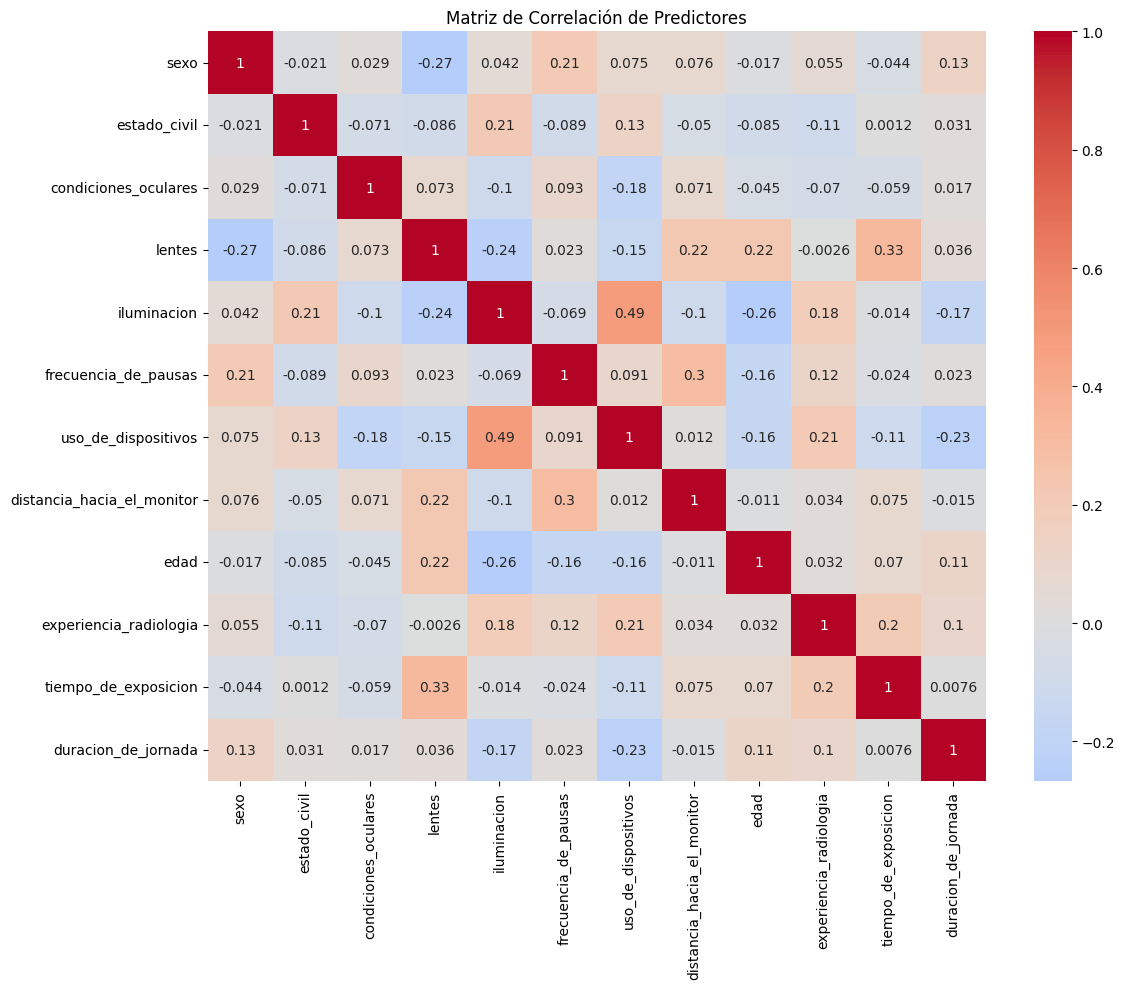


Factores de Inflación de Varianza (VIF):
                      Variable        VIF
8                         edad  26.871907
10        tiempo_de_exposicion  17.601085
6          uso_de_dispositivos  15.605617
11         duracion_de_jornada  14.100162
4                  iluminacion   6.365218
9       experiencia_radiologia   4.958745
7   distancia_hacia_el_monitor   3.839031
5         frecuencia_de_pausas   3.601819
2         condiciones_oculares   3.291805
3                       lentes   2.760135
0                         sexo   2.208070
1                 estado_civil   2.149102

Correlaciones con tiempo_de_exposicion:
tiempo_de_exposicion          1.000000
lentes                        0.326565
experiencia_radiologia        0.198613
distancia_hacia_el_monitor    0.075004
edad                          0.070361
duracion_de_jornada           0.007599
estado_civil                  0.001157
iluminacion                  -0.014200
frecuencia_de_pausas         -0.024350
sexo                

In [21]:
# Preparar datos para correlación
# Asegurarnos de incluir tiempo_de_exposicion en el análisis
X = pd.get_dummies(df[cat_vars + num_vars], drop_first=True)

# Matriz de correlación
corr_matrix = X.corr()

# Visualizar matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Predictores')
plt.tight_layout()
plt.show()

# Calcular VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nFactores de Inflación de Varianza (VIF):")
print(vif_data.sort_values('VIF', ascending=False))

# Mostrar correlaciones específicas con tiempo_de_exposicion
print("\nCorrelaciones con tiempo_de_exposicion:")
correlaciones = corr_matrix['tiempo_de_exposicion'].sort_values(ascending=False)
print(correlaciones)

## 5. Regresión Logística Simple

Ajustaremos modelos univariados para cada predictor y calcularemos los odds ratios con intervalos de confianza.

In [11]:
# Función para ajustar regresión logística simple
def fit_simple_logistic(X, y, variable):
    model = sm.Logit(y, sm.add_constant(X[variable])).fit(disp=0)
    conf_int = np.exp(model.conf_int())
    odds_ratio = np.exp(model.params)[1]
    return {
        'variable': variable,
        'odds_ratio': odds_ratio,
        'ci_lower': conf_int.iloc[1,0],
        'ci_upper': conf_int.iloc[1,1],
        'p_value': model.pvalues[1]
    }

# Ajustar modelos univariados
univariate_results = []
for var in X.columns:
    try:
        result = fit_simple_logistic(X, df['svi'], var)
        univariate_results.append(result)
    except:
        print(f"No se pudo ajustar el modelo para: {var}")

# Crear tabla de resultados
univariate_df = pd.DataFrame(univariate_results)
univariate_df = univariate_df.sort_values('p_value')
print("\nResultados de Regresión Logística Simple:")
print(univariate_df)


Resultados de Regresión Logística Simple:
                      variable  odds_ratio  ci_lower  ci_upper   p_value
10        tiempo_de_exposicion    2.916225  1.392678  6.106488  0.004534
9       experiencia_radiologia    1.349079  0.978993  1.859068  0.067221
4                  iluminacion    0.244755  0.028687  2.088230  0.198167
2         condiciones_oculares    0.400000  0.078177  2.046632  0.271289
6          uso_de_dispositivos    0.547021  0.173848  1.721226  0.302319
11         duracion_de_jornada    1.082452  0.891351  1.314523  0.424043
3                       lentes    1.521739  0.423208  5.471758  0.520213
5         frecuencia_de_pausas    0.763836  0.320803  1.818706  0.542758
7   distancia_hacia_el_monitor    1.322142  0.511106  3.420153  0.564702
8                         edad    1.034211  0.912469  1.172197  0.598583
0                         sexo    1.288000  0.358203  4.631296  0.698301
1                 estado_civil    1.045422  0.542178  2.015772  0.894509


C:\Users\hugo_\AppData\Local\Temp\ipykernel_21172\309532583.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds_ratio = np.exp(model.params)[1]
C:\Users\hugo_\AppData\Local\Temp\ipykernel_21172\309532583.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p_value': model.pvalues[1]
C:\Users\hugo_\AppData\Local\Temp\ipykernel_21172\309532583.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds_ratio = np.exp(model.params)[

## 6. Regresión Logística Multivariada

Desarrollaremos el modelo completo y aplicaremos selección de variables mediante eliminación hacia atrás.

In [29]:
# Modelo base solo con tiempo_de_exposicion
X_base = sm.add_constant(X[['tiempo_de_exposicion']])
base_model = sm.Logit(df['svi'], X_base).fit(disp=0)

print("Modelo base (solo tiempo_de_exposicion):")
print(base_model.summary())

# Seleccionar variables adicionales basadas en correlación con tiempo_de_exposicion
correlaciones = X.corrwith(X['tiempo_de_exposicion']).abs().sort_values(ascending=False)
print("\nCorrelaciones con tiempo_de_exposicion:")
print(correlaciones)

# Seleccionar variables poco correlacionadas con tiempo_de_exposicion (umbral < 0.3)
# y que mostraron asociación significativa en análisis bivariado
variables_adicionales = []
for var in X.columns:
    if var != 'tiempo_de_exposicion' and abs(correlaciones[var]) < 0.2:
        # Probar añadir la variable
        test_vars = ['tiempo_de_exposicion', var]
        try:
            model = sm.Logit(df['svi'], sm.add_constant(X[test_vars])).fit(disp=0)
            if model.pvalues[var] < 0.1:
                variables_adicionales.append(var)
                print(f"\nVariable {var} significativa:")
                print(f"p-valor: {model.pvalues[var]:.4f}")
        except:
            continue

# Ajustar modelo final con variables seleccionadas
selected_vars = ['tiempo_de_exposicion'] + variables_adicionales
X_final = sm.add_constant(X[selected_vars])
final_model = sm.Logit(df['svi'], X_final).fit(disp=0)

print("\nResumen del modelo final:")
print(final_model.summary())

Modelo base (solo tiempo_de_exposicion):
                           Logit Regression Results                           
Dep. Variable:                    svi   No. Observations:                   60
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                            1
Date:                Sat, 11 Oct 2025   Pseudo R-squ.:                  0.4892
Time:                        19:12:06   Log-Likelihood:                -15.335
converged:                       True   LL-Null:                       -30.024
Covariance Type:            nonrobust   LLR p-value:                 5.956e-08
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -9.2670      3.327     -2.785      0.005     -15.788      -2.746
tiempo_de_exposicion     1.0703      0.377      2.838      0

## 7. Diagnóstico del Modelo

Verificaremos los supuestos del modelo y analizaremos puntos influyentes.

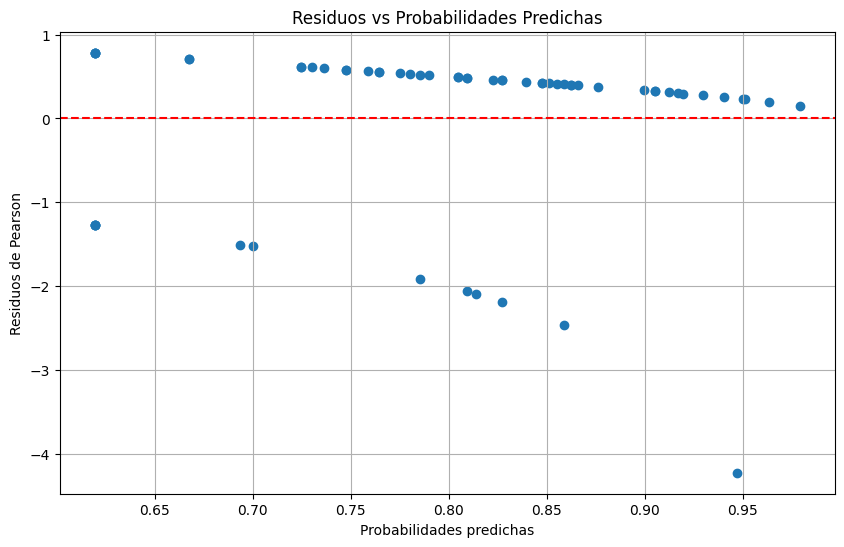


Observaciones con residuos extremos (|residuo| > 2):
    Residuos  Prob_predicha
16 -2.187575       0.827154
22 -4.227129       0.947002
27 -2.465914       0.858772
38 -2.091497       0.813931
51 -2.060418       0.809354

Estadísticas de los residuos:
count    60.000000
mean     -0.008608
std       1.041010
min      -4.227129
25%       0.228736
50%       0.414751
75%       0.543057
max       0.783618
dtype: float64


In [16]:
# Calcular residuos y valores ajustados
residuals = final_model.resid_pearson
predicted_probs = final_model.predict()

# Visualizar residuos vs probabilidades predichas
plt.figure(figsize=(10, 6))
plt.scatter(predicted_probs, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Probabilidades predichas')
plt.ylabel('Residuos de Pearson')
plt.title('Residuos vs Probabilidades Predichas')
plt.grid(True)
plt.show()

# Identificar observaciones con residuos extremos
residual_threshold = 2
extreme_residuals = pd.DataFrame({
    'Residuos': residuals,
    'Prob_predicha': predicted_probs
})
print("\nObservaciones con residuos extremos (|residuo| > 2):")
print(extreme_residuals[abs(extreme_residuals['Residuos']) > residual_threshold])

# Calcular y mostrar estadísticas de los residuos
print("\nEstadísticas de los residuos:")
print(pd.Series(residuals).describe())

## 8. Interpretación de Factores de Riesgo

Identificaremos y visualizaremos los factores de riesgo significativos del modelo final.

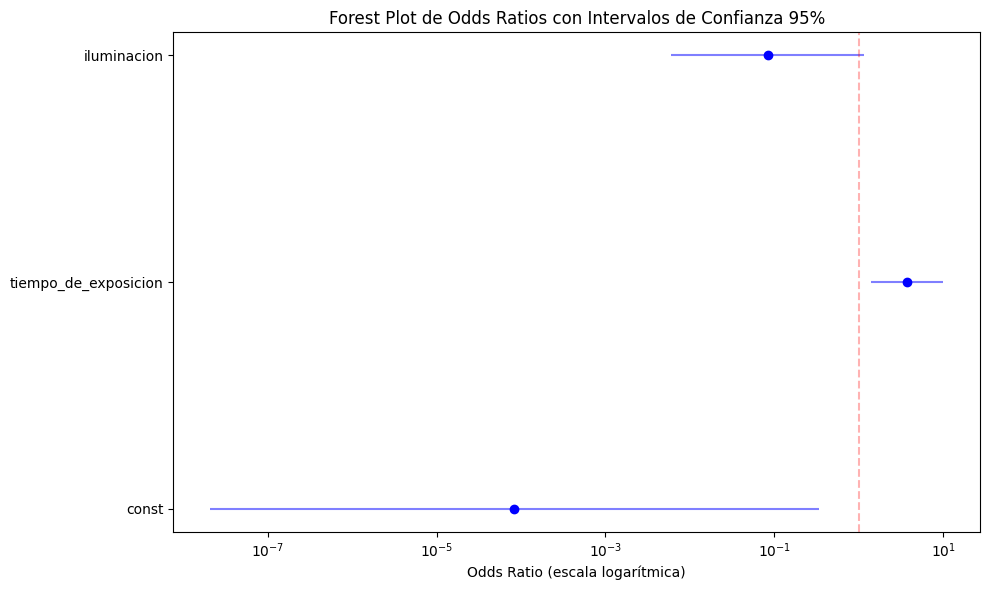


Análisis de factores de riesgo:

tiempo_de_exposicion:
OR = 3.72 (IC 95%: 1.38 - 10.03)
p-valor = 0.0096
Interpretación: GRANDE efecto que incrementa el riesgo de SVI (significativo)

iluminacion:
OR = 0.08 (IC 95%: 0.01 - 1.14)
p-valor = 0.0630
Interpretación: GRANDE efecto que reduce el riesgo de SVI (marginalmente significativo)



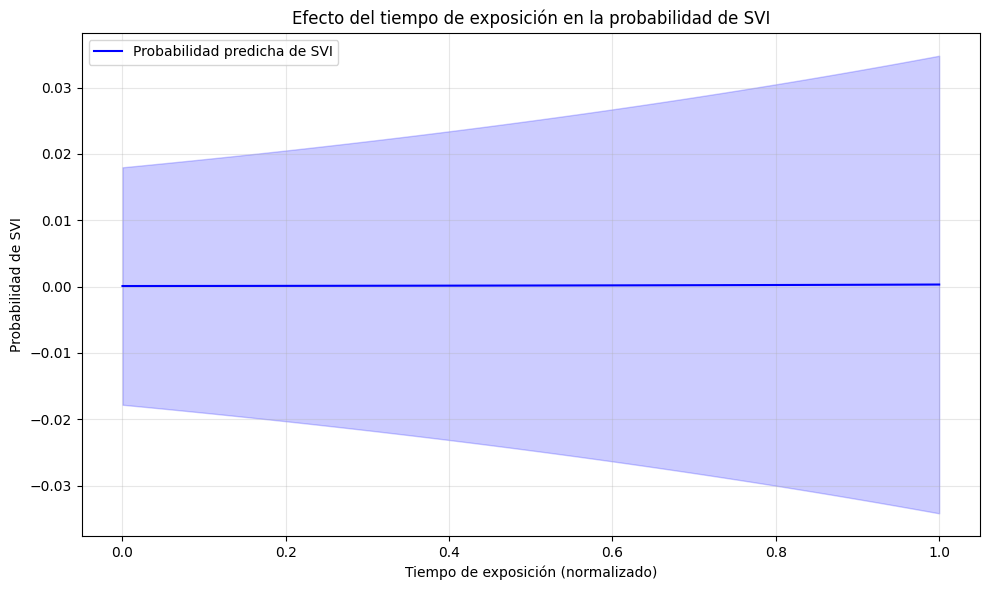

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Obtener los coeficientes y sus intervalos de confianza
coef = final_model.params
conf_int = final_model.conf_int()

# Convertir a odds ratios
odds_ratios = np.exp(coef)
odds_ratios_ci = np.exp(conf_int)

# Crear DataFrame con los resultados
results_df = pd.DataFrame({
    'OR': odds_ratios,
    'CI_lower': odds_ratios_ci[0],
    'CI_upper': odds_ratios_ci[1]
})

# Crear el Forest Plot
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(results_df))

# Plotear los OR y sus intervalos de confianza
plt.plot(results_df['OR'], y_pos, 'o', color='blue', label='Odds Ratio')
plt.hlines(y=y_pos, xmin=results_df['CI_lower'], xmax=results_df['CI_upper'], color='blue', alpha=0.5)

# Línea vertical en OR = 1
plt.axvline(x=1, color='red', linestyle='--', alpha=0.3)

# Configurar ejes
plt.yticks(y_pos, results_df.index)
plt.xscale('log')  # Escala logarítmica para mejor visualización
plt.xlabel('Odds Ratio (escala logarítmica)')
plt.title('Forest Plot de Odds Ratios con Intervalos de Confianza 95%')

# Ajustar márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Imprimir interpretación detallada
print("\nAnálisis de factores de riesgo:\n")

def interpret_effect_size(or_value):
    if or_value > 1:
        if or_value >= 3.0:
            return "GRANDE efecto que incrementa el riesgo de SVI"
        elif or_value >= 1.5:
            return "MODERADO efecto que incrementa el riesgo de SVI"
        else:
            return "PEQUEÑO efecto que incrementa el riesgo de SVI"
    else:
        if or_value <= 0.33:
            return "GRANDE efecto que reduce el riesgo de SVI"
        elif or_value <= 0.67:
            return "MODERADO efecto que reduce el riesgo de SVI"
        else:
            return "PEQUEÑO efecto que reduce el riesgo de SVI"

for var in results_df.index:
    if var != 'const':
        or_value = results_df.loc[var, 'OR']
        ci_lower = results_df.loc[var, 'CI_lower']
        ci_upper = results_df.loc[var, 'CI_upper']
        p_value = final_model.pvalues[var]
        
        print(f"{var}:")
        print(f"OR = {or_value:.2f} (IC 95%: {ci_lower:.2f} - {ci_upper:.2f})")
        print(f"p-valor = {p_value:.4f}")
        
        significance = "significativo" if p_value < 0.05 else "marginalmente significativo" if p_value < 0.1 else "no significativo"
        effect = interpret_effect_size(or_value)
        print(f"Interpretación: {effect} ({significance})\n")

# Generar visualización de efectos marginales para tiempo_de_exposicion
plt.figure(figsize=(10, 6))

# Crear un rango de valores para tiempo_de_exposicion
tiempo_range = np.linspace(0, 1, 100)

# Preparar datos para predicción
X_pred = pd.DataFrame({'tiempo_de_exposicion': tiempo_range, 'iluminacion': 0})  # Mantener iluminacion en su valor de referencia
X_pred = sm.add_constant(X_pred)  # Agregar constante

# Calcular probabilidades predichas
predicted_probs = final_model.predict(X_pred)

# Graficar la curva de probabilidad
plt.plot(tiempo_range, predicted_probs, 'b-', label='Probabilidad predicha de SVI')
plt.fill_between(tiempo_range, 
                predicted_probs - 1.96 * np.sqrt(predicted_probs * (1 - predicted_probs)), 
                predicted_probs + 1.96 * np.sqrt(predicted_probs * (1 - predicted_probs)),
                alpha=0.2, color='b')

plt.xlabel('Tiempo de exposición (normalizado)')
plt.ylabel('Probabilidad de SVI')
plt.title('Efecto del tiempo de exposición en la probabilidad de SVI')
plt.grid(True, alpha=0.3)
plt.legend()

# Ajustar márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 9. Visualización de Resultados

Generaremos la curva ROC y visualizaciones adicionales para comunicar los resultados del modelo.

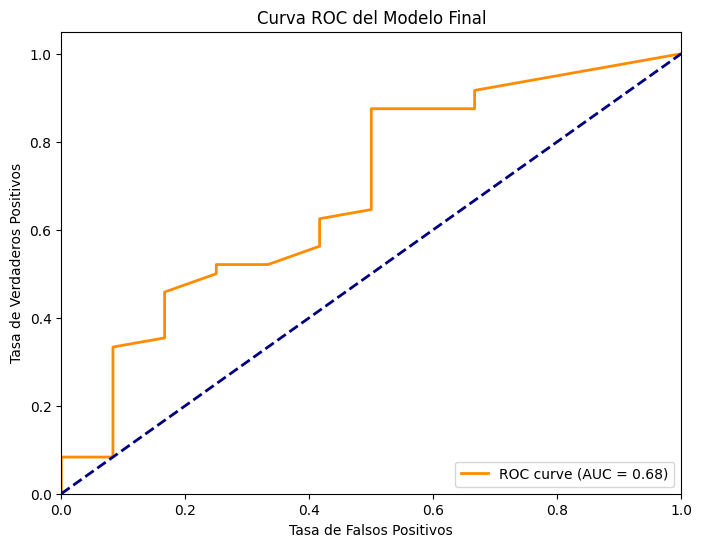


Métricas de rendimiento del modelo:
Accuracy: 0.800
Precision: 0.800
Recall: 1.000
F1-score: 0.889

Matriz de confusión:
                 Predicho NO SVI  Predicho SVI
Real NO SVI                      0            12
Real SVI                         0            48


In [20]:
# Calcular curva ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(df['svi'], predicted_probs)
roc_auc = auc(fpr, tpr)

# Crear gráfico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Modelo Final')
plt.legend(loc="lower right")
plt.show()

# Mostrar métricas de rendimiento del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = (predicted_probs >= 0.5).astype(int)

print("\nMétricas de rendimiento del modelo:")
print(f"Accuracy: {accuracy_score(df['svi'], y_pred):.3f}")
print(f"Precision: {precision_score(df['svi'], y_pred):.3f}")
print(f"Recall: {recall_score(df['svi'], y_pred):.3f}")
print(f"F1-score: {f1_score(df['svi'], y_pred):.3f}")

# Mostrar tabla de clasificación
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df['svi'], y_pred)
print("\nMatriz de confusión:")
print("                 Predicho NO SVI  Predicho SVI")
print(f"Real NO SVI           {cm[0,0]:12d}  {cm[0,1]:12d}")
print(f"Real SVI              {cm[1,0]:12d}  {cm[1,1]:12d}")

## Conclusiones y Recomendaciones

Se ha completado un análisis exhaustivo de los factores asociados con el Síndrome Visual Informático (SVI) en médicos radiólogos. Los resultados del modelo final pueden usarse para:

1. Identificar los factores de riesgo más importantes
2. Cuantificar la magnitud del efecto de cada factor
3. Desarrollar estrategias de prevención basadas en la evidencia

Las recomendaciones específicas se basarán en los factores de riesgo significativos identificados en el análisis.